## Instructions to run this code:

##### This notebook is for EXP13 : i.e., using the VGGNet architecture on 384x384 grid-size with cross-validation and 74 epochs 

##### This notebook can be run from start to end. Please check and change the data path before running if needed

##### The results will be saved in the "../results/" folder  

In [1]:
#REFERENCES:
#https://medium.com/@tifa2up/image-classification-using-deep-neural-networks-a-beginner-friendly-approach-using-tensorflow-94b0a090ccd4
#https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/

In [1]:
#CELL 1

import numpy as np
import pandas as pd
import csv
import cv2
import glob
import shutil
import os
import subprocess
import random
import tensorflow
import itertools
from tensorflow.keras.models import model_from_json
import sklearn
import scipy
from collections import defaultdict
from scipy.ndimage import rotate
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import CSVLogger
from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
plt.figure(figsize=(12,6))
import pydot

<Figure size 864x432 with 0 Axes>

In [2]:
#CELL 2

#Change this to local path before running
data_path = '/home/dnyanadajoshi/data/'

#Conceptually global for this notebook
detect = data_path+"detection_data/"
positive_path = detect+"positive/"
negative_path = detect+"negative/"
results = "../results/"
ext = ".bmp"

#TODO: check pros and cons for os, subprocess, shutil - MAKE A NOTE SOMEWHERE
def remove_nonsquares(negative):
    
    files = glob.glob(negative+"*"+ext)
    for f in files:
        img = cv2.imread(f,0)
        if img.shape != (60,60):
            os.remove(f)
            
def create_dataset(path):
    
    files = glob.glob(data_path+"??_cropped/??_?/names_*.csv")
    subprocess.run(["mkdir", detect[:-1]])
    subprocess.run(["mkdir", positive_path[:-1]])
    subprocess.run(["mkdir", negative_path[:-1]])
    output_file = open(detect+"detection_labels.csv","w")
    writer = csv.writer(output_file)
    for fi in files:
        with open(fi,"r") as f:
            reader = csv.reader(f)
            for row in reader:
                (name, label) = tuple(row)
                label_path = negative_path
                if label == '1':
                    label_path = positive_path
                shutil.copyfile(data_path+name, label_path+name.split("/")[-1])
    remove_nonsquares(negative_path)
    files = glob.glob(positive_path+"*"+ext)
    for f in files:
        writer.writerow([f, '1'])
    files = glob.glob(negative_path+"*"+ext)
    for f in files:
        writer.writerow([f, '0'])
    output_file.close()
create_dataset(data_path)

In [3]:
#CELL 3

def load_dataset(path, split=0.8):
    X = [[], []]
    #Y = []
    data = []
    with open(path,"r") as f:
        reader = csv.reader(f)
        for row in reader:
            (name, label) = tuple(row)
            img = name
            if label == "1":
                X[1].append(img)
            else:
                X[0].append(img)
        f.close()
        return (X)

X = load_dataset(data_path+"labels-full-384.csv")
random.shuffle(X[0])
random.shuffle(X[1])
circuits_neg = [x.split("offset",1)[0] for x in X[0]]
circuits_pos = [x.split("offset",1)[0] for x in X[1]]
print("Circuits: ", len(set(circuits_neg))+len(set(circuits_pos)))
print("Positives : ", len(X[1]))
print("Negatives : ", len(X[0]))

Circuits:  96
Positives :  475
Negatives :  16115


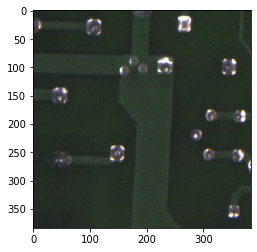

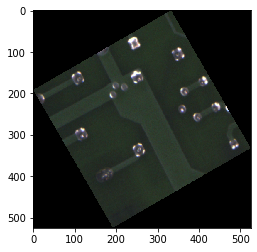

In [4]:
#CELL 4

t_o = 6 #Total image operations: identity, rot90, rot180, rot270, flipUpDown, flipLeftRight
upper_limit = len(X[1])*t_o
del X[0][len(X[1]):]
P = len(X[1])
N = len(X[0])
#dummy_img = cv2.imread(X[1][0])
#plt.imshow(dummy_img)
#plt.show()
#plt.imshow(rotate(dummy_img, 30, reshape=True))
#plt.show()
(height, width, ch) = dummy_img.shape
Xdata = np.zeros((upper_limit*2, height, width, ch), dtype=np.int8)
for i in range(N):
    img = cv2.imread(X[0][i])
    Xdata[t_o*i] = img
    Xdata[t_o*i+1] = rotate(img, 90, reshape=False)
    Xdata[t_o*i+2] = rotate(img, 180, reshape=False)
    Xdata[t_o*i+3] = rotate(img, 270, reshape=False)
    Xdata[t_o*i+4] = np.flipud(img)
    Xdata[t_o*i+5] = np.fliplr(img)
for i in range(P):
    
    img = cv2.imread(X[1][i])
    Xdata[upper_limit+t_o*i] = img
    Xdata[upper_limit+t_o*i+1] = rotate(img, 90, reshape=False)
    Xdata[upper_limit+t_o*i+2] = rotate(img, 180, reshape=False)
    Xdata[upper_limit+t_o*i+3] = rotate(img, 270, reshape=False)
    Xdata[upper_limit+t_o*i+4] = np.flipud(img)
    Xdata[upper_limit+t_o*i+5] = np.fliplr(img)

X = Xdata
del Xdata

#EXP2 : Synthetically augment both positives and negatives
##Separate positives and negatives
##You can change upper_limit to control number of negatives picked

upper_limit = 14000
del X[0][len(X[1]):]
X_pos = []
X_neg = []
for p in X[1]:
    img = cv2.imread(p)
    X_pos.append(img)
X_pos_arr = np.asarray(X_pos)
height = X_pos_arr[0].shape[0]
width = X_pos_arr[0].shape[1]
ch = X_pos_arr[0].shape[2]
del X_pos
for n in X[0]:
    img = cv2.imread(n)
    X_neg.append(img)
X_neg_arr = np.asarray(X_neg)
del X_neg

##Data augmentation

N = len(X[0])
P = len(X[1])
ratio = 0.5
sample_factor = int((ratio/(1-ratio))*(upper_limit/P))+1
print(P*sample_factor)
img_gen = ImageDataGenerator(rotation_range=180,horizontal_flip=True, vertical_flip=True, dtype="uint8")
pos_gen = img_gen.flow(X_pos_arr, None, batch_size=len(X[1]))
neg_gen = img_gen.flow(X_neg_arr, None, batch_size=len(X[0]))

Xdata = np.zeros((2*P*sample_factor, height, width, ch), dtype = np.int8) 
for i in range(N): 
    img = cv2.imread(X[0][i]) 
    Xdata[i] = img

    #Load positives after negatives (augmented size)
    img = cv2.imread(X[1][i])
    Xdata[upper_limit+i] = img
del X 
for i in range(sample_factor-1): 
    batch = neg_gen.next() 
    for b in range(len(batch)): 
        Xdata[N + i*b] = batch[b]

for i in range(sample_factor-1): 
    batch = pos_gen.next() 
    for b in range(len(batch)): 
        Xdata[upper_limit + N + i*b] = batch[b]

X = Xdata[:2*upper_limit]
del Xdata

#EXP1 : Synthetically augment only positives
##Separate positives and negatives

upper_limit = 14000
del X[0][upper_limit:]
X_pos = []
X_neg = []
for p in X[1]:
    img = cv2.imread(p)
    X_pos.append(img)
X_pos_arr = np.asarray(X_pos)
height = X_pos_arr[0].shape[0]
width = X_pos_arr[0].shape[1]
ch = X_pos_arr[0].shape[2]
del X_pos

##Data augmentation

N = len(X[0])
P = len(X[1])
ratio = 0.5
sample_factor = int((ratio/(1-ratio))*(upper_limit/P))+1
print(P*sample_factor)
img_gen = ImageDataGenerator(rotation_range=180,horizontal_flip=True, vertical_flip=True, dtype="uint8")
pos_gen = img_gen.flow(X_pos_arr, None, batch_size=len(X[1]))

Xdata = np.zeros((2*P*sample_factor, height, width, ch), dtype = np.int8) 
for i in range(N): 
    img = cv2.imread(X[0][i]) 
    Xdata[i] = img

del X 
for i in range(sample_factor): 
    batch = pos_gen.next() 
    for b in range(len(batch)): 
        Xdata[N + i*b] = batch[b]
X = Xdata[:2*upper_limit]
del Xdata

In [3]:
#CELL 5

#suffix for saving data"
#Change this whenever running different experiments
EXP = "_exp13"

Xdata = np.zeros((2*P*sample_factor, height, width, ch), dtype = np.int8)
for i in range(N):
    img = cv2.imread(X[0][i])
    Xdata[i] = img
    
    #Load positives after negatives (augmented size)
    img = cv2.imread(X[1][i])
    Xdata[upper_limit+i] = img

del X
for i in range(sample_factor-1):
    batch = neg_gen.next()
    for b in range(len(batch)):
        Xdata[N + i*b] = batch[b]

for i in range(sample_factor-1):
    batch = pos_gen.next()
    for b in range(len(batch)):
        Xdata[upper_limit + N + i*b] = batch[b]

In [6]:
#CELL 6

Y = [0 for i in range(2*upper_limit)]
for i in range(upper_limit):
    Y[upper_limit+i] = 1
#Ydata = np.float32(Y)
Ycat = to_categorical(Y)
del Y
Xdata, Ydata = sklearn.utils.shuffle(X, Ycat)
del X
del Ycat
#THIS IS OPTIONAL


In [7]:
#print(Xdata.shape)
p = {'a':0.44,'bb':999}
str(p)

"{'a': 0.44, 'bb': 999}"

In [4]:
#CELL 7

#THIS IS OPTIONAL
np.save("../Augmented-data/data"+EXP, Xdata)
np.save("../Augmented-data/labels"+EXP,Ydata)
#del X
del Ydata
Xdata = np.load("../Augmented-data/data"+EXP+".npy")
Ydata = np.load("../Augmented-data/labels"+EXP+".npy")
(new_height, new_width, ch) = Xdata[0].shape

def data_gen():
    
    batch_pos, labels_pos = aug_gen.next()
    ngen = neg_gen(Xneg, Yneg, 16)
    batch_neg, labels_neg = next(ngen)
    yield np.vstack([batch_pos, batch_neg]), np.vstack([labels_pos, labels_neg])
    
for i in range(2):
    
    #plt.imshow(np.uint8(batch[34]))
    plt.show()
    for i in range(16):
        plt.subplot(4,4,1+i)
        plt.imshow(np.uint8(Xdata[i]))
    counter += 1
    plt.show()
    print(batch.shape, labels.shape)

In [5]:
#CELL 8

Xtrain = Xdata[:int(0.8*len(Xdata))]#[:32]
Xval = Xdata[int(0.8*len(Xdata)):]
Ytrain = Ydata[:int(0.8*len(Ydata))]#[:32]
Yval = Ydata[int(0.8*len(Ydata)):]
del Xdata
del Ydata

In [6]:
print(Xtrain[0].shape)

(384, 384, 3)


#Data generator
img_gen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, dtype="uint8")
Xtrain = X[:int(0.008*len(X))]
Xtrain = X[:10]
#Xval = X[int(0.8*len(X)):]
Ytrain = Y[:int(0.008*len(Y))]
Ytrain = Y[:10]
#Yval = Y[int(0.8*len(Y)):]
print(sum(np.argmin(Ytrain, axis=1)))
print(len(X), len(Ytrain))
batch_size = 5
train_gen = img_gen.flow(Xtrain, Ytrain, batch_size=batch_size)
#val_gen = img_gen.flow(Xval, Yval, batch_size = 32)
fig = plt.figure()
batch,labels = train_gen.next()
counter = 0
for j in range(2): 
    batch,labels = train_gen.next()
    for i in range(len(batch)):
        plt.subplot(2,5,1+i)
        plt.imshow(np.uint8(batch[i]))
    counter += 1
    plt.show()

#### Old model
(height, width, ch) = Xtrain[0].shape
def Model(learn_rate = 0.01, n_layers=1, n_feature_maps=32,  mm = 0.9, dropout = 0.0):
    model = Sequential()
    for i in range(n_layers):
        model.add(Conv2D(n_feature_maps, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(height, width, ch)))
        model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(dropout))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dense(2, activation='softmax'))
    # compile model
    opt = SGD(lr=learn_rate, momentum=mm)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model
#plot_model(model, to_file=results+'model.png', show_shapes=True)

In [5]:
#CELL 9

#Reference: https://keras.io/applications/#vgg16
#Reference: https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/
#Reference: https://stackoverflow.com/questions/44495698/keras-difference-between-kernel-and-activity-regularizers
#For now we are using kernel (i.e. weights) regularization
def Model(learn_rate=0.01, L1=0, L2=0, fc=4096, mm = 0.9):
    K.clear_session()
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same',input_shape=(new_height, new_width, ch)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Flatten())
    print(model.output_shape)
    model.add(Dense(fc, activation='relu', kernel_regularizer=regularizers.l1_l2(l1 = L1, l2 = L2)))
    model.add(Dense(fc, activation='relu', kernel_regularizer=regularizers.l1_l2(l1 = L1, l2 = L2)))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer=SGD(lr = learn_rate, momentum=mm), loss='binary_crossentropy', metrics=['accuracy'])
    return model

#Use sklearn train test split, also use test data separately
#model.fit_generator(train_gen, epochs=3,steps_per_epoch = Xtrain.shape[0]//batch_size, validation_data=(Xval, Yval), verbose = 1)
history = model.fit(x=Xtrain, y=Ytrain, batch_size=32, epochs=20, validation_data=(Xval, Yval))



model_json = model.to_json()
with open("../Models/model"+EXP+".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("../Models/model"+EXP+".h5")

#REFERENCE: http://danielhnyk.cz/adding-callback-to-a-sklearn-gridsearch/

import pickle  
import time  
import json

def log_metrics_and_params(results, model_savepath):  
    # log results and save path
    to_write = {}
    to_write['results'] = results
    to_write['model_savepath'] = model_savepath
    log.info('%s', json.dumps(to_write))


def save_model(clf):  
    # save model with timestamp
    timestring = "".join(str(time.time()).split("."))
    model_savepath = '../results/model_' + timestring + '.pk'
    with open(model_savepath, 'wb') as ofile:
        pickle.dump(clf, ofile)
    return model_savepath

def get_train_metrics():  
    # currently impossible
    # X_train and y_train are in higher scopes
    pass

def get_val_metrics(y_pred, y_true):  
    return get_metrics(y_pred, y_true)

def get_metrics(y_pred, y_true):  
    # compute more than just one metrics

    chosen_metrics = {
        #'conf_mat': metrics.confusion_matrix,
        'accuracy': metrics.accuracy_score,
        #'auc' : metrics.roc_auc_score,
    }

    results = {}
    for metric_name, metric_func in chosen_metrics.items():
        try:
            inter_res = metric_func(y_pred, y_true)
        except Exception as ex:
            inter_res = None
            print("Couldn't evaluate %s because of %s", metric_name, ex)
        results[metric_name] = inter_res

    #results['conf_mat'] = results['conf_mat'].tolist()

    return results


def _my_scorer(model, X_val, Y_val):  
    # do all the work and return some of the metrics
    print(type(model))
    y_pred_val = model.predict(X_val)
    print("REAL STUFFFF: ", y_true_val[:5])
    #yhat_classes = np.argmax(y_pred_val, axis=1)
    Yval_ = np.argmax(y_true_val, axis=1)
    results = get_val_metrics(y_pred_val, y_true_val)
    model_savepath = save_model(clf)
    #log_metrics_and_params(results, model_savepath)
    return results['accuracy']

In [6]:
#CELL 10

#Reference : https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=0)
cvscores = []
history_dict = {}
file = open("../results/crossval"+EXP+"_run2.csv", "w")
writer = csv.writer(file)
writer.writerow(['accuracy','TP','FP','TN','FN','precision','recall'])
counter = 0

for train, val in kfold.split(Xdata, np.argmax(Ydata, axis=1)):
    # create model
    model = Model()
    # Fit the model
    #csv_logger = CSVLogger('../results/training'+EXP+'_'+str(counter)+'.log')
    model.fit(Xdata[train], Ydata[train], epochs=1, batch_size=32)
    #history_dict[counter] = history.history
    # evaluate the model
    #scores = model.evaluate(Xtrain[val], Ytrain[val], verbose=0)
    
    yhat_probs_class = model.predict(Xdata[val], verbose=0)
    yhat_probs = yhat_probs_class[:, 0]
    # predict crisp classes for test set
    #yhat_classes = model.predict_classes(Xval, verbose=0)
    yhat_classes = np.argmax(yhat_probs_class, axis=1)
    Yval_ = np.argmax(Ydata[val], axis=1)
    accuracy = accuracy_score(Yval_, yhat_classes)
    #tp_index = []
    #for i in range(30):
    #    if Yval_[i] and yhat_classes[i]:
    #        tp_index.append(i)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    matrix = confusion_matrix(Yval_, yhat_classes)
    TN = matrix[0][0]
    FP = matrix[0][1]
    FN = matrix[1][0]
    TP = matrix[1][1]
    precision = TP/(TP+FP)
    print("Precision: ", precision)
    #Fraction of positives predicted correctly
    recall = TP/(TP+FN)
    print("Recall: ", recall)
    #print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    #cvscores.append(scores[1] * 100)
    writer.writerow([accuracy,TP,FP,TN,FN,precision,recall])
    file.flush()
    #model.save("../Models/models_"+str(counter)+EXP+".h5")
    counter += 1
#file.write("Mean :"+str(np.mean(np.asarray(cvscores))))
#pickle.dump(history_dict, open("history"+EXP+".p", "wb"))
file.close()

Instructions for updating:
Colocations handled automatically by placer.
(None, 4608)
Instructions for updating:
Use tf.cast instead.
Epoch 1/74
4750/4750 [==============================] - 114s 24ms/sample - loss: 0.6691 - acc: 0.5764
Epoch 2/74
4750/4750 [==============================] - 109s 23ms/sample - loss: 0.5975 - acc: 0.6834
Epoch 3/74
4750/4750 [==============================] - 109s 23ms/sample - loss: 0.5900 - acc: 0.6998
Epoch 4/74
4750/4750 [==============================] - 109s 23ms/sample - loss: 0.5910 - acc: 0.6811
Epoch 5/74
4750/4750 [==============================] - 109s 23ms/sample - loss: 0.5587 - acc: 0.7238
Epoch 6/74
4750/4750 [==============================] - 109s 23ms/sample - loss: 0.5426 - acc: 0.7331
Epoch 7/74
4750/4750 [==============================] - 109s 23ms/sample - loss: 0.5556 - acc: 0.7162
Epoch 8/74
4750/4750 [==============================] - 109s 23ms/sample - loss: 0.6044 - acc: 0.6869
Epoch 9/74
4750/4750 [=============================

Epoch 74/74
4750/4750 [==============================] - 109s 23ms/sample - loss: 6.4640e-05 - acc: 1.0000
Accuracy: 0.921053
Precision:  0.890625
Recall:  0.96
(None, 4608)
Epoch 1/74
4750/4750 [==============================] - 109s 23ms/sample - loss: 0.6911 - acc: 0.5324
Epoch 2/74
4750/4750 [==============================] - 109s 23ms/sample - loss: 0.6842 - acc: 0.5419
Epoch 3/74
4750/4750 [==============================] - 109s 23ms/sample - loss: 0.6933 - acc: 0.5046
Epoch 4/74
4750/4750 [==============================] - 109s 23ms/sample - loss: 0.6859 - acc: 0.5467
Epoch 5/74
4750/4750 [==============================] - 109s 23ms/sample - loss: 0.6944 - acc: 0.4821
Epoch 6/74
4750/4750 [==============================] - 109s 23ms/sample - loss: 0.6786 - acc: 0.5943
Epoch 7/74
4750/4750 [==============================] - 109s 23ms/sample - loss: 0.6037 - acc: 0.6931
Epoch 8/74
4750/4750 [==============================] - 109s 23ms/sample - loss: 0.5862 - acc: 0.6945
Epoch 9/74

4750/4750 [==============================] - 109s 23ms/sample - loss: 0.6944 - acc: 0.4992
Epoch 5/74
4750/4750 [==============================] - 109s 23ms/sample - loss: 0.6580 - acc: 0.6232
Epoch 6/74
4750/4750 [==============================] - 109s 23ms/sample - loss: 0.6091 - acc: 0.6884
Epoch 7/74
4750/4750 [==============================] - 109s 23ms/sample - loss: 0.6040 - acc: 0.6928
Epoch 8/74
4750/4750 [==============================] - 109s 23ms/sample - loss: 0.5856 - acc: 0.7074
Epoch 9/74
4750/4750 [==============================] - 109s 23ms/sample - loss: 0.5727 - acc: 0.7135
Epoch 10/74
4750/4750 [==============================] - 109s 23ms/sample - loss: 0.5379 - acc: 0.7461
Epoch 11/74
4750/4750 [==============================] - 109s 23ms/sample - loss: 0.5355 - acc: 0.7453
Epoch 12/74
4750/4750 [==============================] - 109s 23ms/sample - loss: 0.5217 - acc: 0.7575
Epoch 13/74
4750/4750 [==============================] - 109s 23ms/sample - loss: 0.4902 -

ResourceExhaustedError: OOM when allocating tensor with shape[32,64,384,384] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training/SGD/gradients/conv2d_1/Conv2D_grad/Conv2DBackpropInput}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


#Grid search 
pd = {"lr":0, "L1":1, "L2":2, "fc":3}
params = []
lr = [0.01, 0.005]
l1_reg = [0, 0.005]
l2_reg = [0.005]
fc_count = [4096]
params = [lr,l1_reg,l2_reg,fc_count]
params = list(itertools.product(*params))
for p in params:
    
    #param_dict = dict(learn_rate=p[pd["lr"]], L1=p[pd["L1"]], L2=p[pd["L2"]], fc=p[pd["fc"]])
    model = KerasClassifier(build_fn=Model, epochs = 10, batch_size = 32, learn_rate=p[pd["lr"]], L1=p[pd["L1"]], L2=p[pd["L2"]], fc=p[pd["fc"]])
    scores = cross_validate(model, Xtrain[:32], y=Ytrain[:32], cv = 10, verbose=10,return_train_score=True, return_estimator=True)
    print("ESTIMATOR: ", type(scores['estimator']))
    

#Grid search 
model = KerasClassifier(build_fn=Model, epochs = 10, batch_size = 32)
params = []
lr = [0.01, 0.005]
l1_reg = [0, 0.005]
l2_reg = [0.005]
fc_count = [4096]
params = [lr,l1_reg,l2_reg,fc_count]
print(list(itertools.product(*params)))
param_grid = dict(learn_rate=lr, L1=l1_reg, L2=l2_reg, fc=fc_count)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, verbose=20, scoring=_my_scorer)
grid_result = grid.fit(Xtrain[:32], Ytrain[:32])
save_result = grid_result.cv_results_
print("Mean test scores: ", save_result["mean_test_score"])
print("Params: ", save_result["params"])
pickle.dump(save_result, open("../results/latest_results_clear_sess"+EXP+".p","wb"))
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for params, mean_score, scores in grid_result.grid_scores_:
    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))
print("total time:",time()-start)

f = open('../Models/model'+EXP+'.json', 'r')
model = model_from_json(f.read())

# Load weights into the new model
model.load_weights('../Models/model'+EXP+'.h5')
model.compile(optimizer=SGD(lr=0.01, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

In [6]:
#CELL 11

def evaluate(Xtest, Ytest, model, metrics ):
    scores = model.evaluate(Xtest, Ytest,verbose=0)
    for m in range(len(metrics)):
        print(metrics[m],": ",scores[m])

#model = load_model('../Models/models_9_exp12.h5')
#hist = pickle.load(open("history_exp12.p","rb"))
#print(hist[0])
evaluate(Xval, Yval, model, model.metrics_names)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
loss :  1.6426726474621904
acc :  0.7950601


In [20]:
#CELL 12

#PLEASE RUN THIS CELL TWICE TO SAVE RESULTS (BUG)
print(history.history)
val_acc = history.history['val_acc']
loss = history.history['loss']
acc = history.history['acc']
val_loss = history.history['val_loss']
f = open("../results/results"+EXP+".csv","w")
writer = csv.writer(f)
for i in range(len(val_acc)):
    writer.writerow([acc[i], loss[i], val_acc[i], val_loss[i]])

{'loss': [0.6795691021884787, 0.6529327843702156, 0.5955452380848092, 0.5516588785667194, 0.5538281305303417, 0.5102860719924724, 0.48098115931790403, 0.4843135147630529, 0.43300134707547255, 0.40490094451565045, 0.37426000742640353, 0.35357632975602543, 0.33219365821862074, 0.3012057992696493, 0.2651101918559772, 0.2819314560206646, 0.2604742025854492, 0.1871828720486817, 0.18505056345449336, 0.15575284035040254], 'acc': [0.5429136, 0.6109543, 0.68944097, 0.7261434, 0.7247318, 0.7625635, 0.77470356, 0.77357423, 0.8094297, 0.81648785, 0.83738, 0.8469791, 0.8562959, 0.8738001, 0.89469224, 0.8833992, 0.8961039, 0.9282891, 0.93421793, 0.9390175], 'val_loss': [0.6936391896103629, 0.6464895420365085, 0.6185370745562, 0.5944559652164881, 0.5800112047260018, 0.6426956412754532, 0.5882928861855923, 0.495626088593399, 0.46333570203178354, 0.445240040295011, 0.4959666846029914, 0.4285929948427876, 0.4881814681245834, 0.4744870358611337, 0.6403363224615093, 0.6649375564626862, 0.4756773616067443,

In [21]:
#CELL 13

df = pd.read_csv("../results/results"+EXP+".csv",header=None, names=["acc", "loss", "val_acc","val_loss"])
val_acc = list(df["val_acc"])
acc = list(df["acc"])
val_loss = list(df["val_loss"])
loss = list(df["loss"])

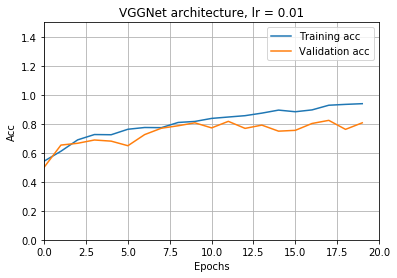

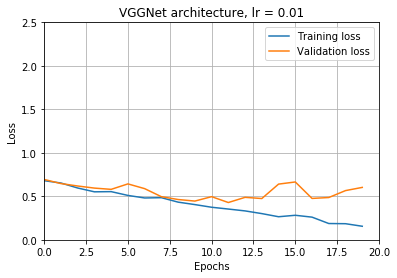

In [25]:
#CELL 14

plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.plot(df["acc"])
plt.plot(df["val_acc"])
plt.ylim(0, 1.5)
plt.xlim(0,20)
plt.title("VGGNet architecture, lr = 0.01")
plt.grid()
plt.legend(['Training acc','Validation acc'],loc="upper right")
plt.savefig("../results/Acc-loss-curves/acc_"+EXP+".png")
plt.show()

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(df["loss"])
plt.plot(df["val_loss"])
plt.ylim(0, 2.5)
plt.xlim(0,20)
plt.title("VGGNet architecture, lr = 0.01")
plt.grid()
plt.legend(['Training loss','Validation loss'],loc="upper right")
plt.savefig("../results/Acc-loss-curves/loss_"+EXP+".png")
plt.show()


Accuracy: 0.795060
Precision: 0.773795
Recall: 0.773795
ROC AUC: 0.138970
[0.0, 0.19826435246995994, 0.2096128170894526, 0.21562082777036048, 0.22296395193591456, 0.22496662216288385, 0.23030707610146864, 0.23230974632843793, 0.2336448598130841, 0.2356475300400534, 0.24032042723631508, 0.2416555407209613, 0.24232309746328437, 0.24566088117489987, 0.24632843791722298, 0.24833110814419226, 0.25033377837116155, 0.2523364485981308, 0.25634178905206945, 0.2576769025367156, 0.2596795727636849, 0.26101468624833113, 0.2650200267022697, 0.26635514018691586, 0.2683578104138852, 0.2696929238985314, 0.27169559412550065, 0.27303070761014686, 0.27436582109479307, 0.2757009345794392, 1.0]
[[565 183]
 [124 626]]
Precision:  0.7737948084054388
Recall:  0.8346666666666667


/home/dnyanadajoshi/anaconda3/envs/project/lib/python3.7/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


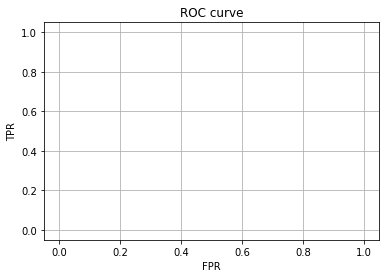

In [7]:
#CELL 15

#Metrics
# predict probabilities for test set

yhat_probs_class = model.predict(Xval, verbose=0)
yhat_probs = yhat_probs_class[:, 0]
# predict crisp classes for test set
#yhat_classes = model.predict_classes(Xval, verbose=0)
yhat_classes = np.argmax(yhat_probs_class, axis=1)
Yval_ = np.argmax(Yval, axis=1)
accuracy = accuracy_score(Yval_, yhat_classes)
tp_index = []
for i in range(30):
    if Yval_[i] and yhat_classes[i]:
        tp_index.append(i)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(Yval_, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(yhat_classes, Yval_)
print('Recall: %f' % recall)
fpr, tpr, thresholds = metrics.roc_curve(Yval_, yhat_probs, pos_label=2)
auc = roc_auc_score(Yval_,yhat_probs)
print('ROC AUC: %f' % auc)
print(list(fpr))
# confusion matrix
matrix = confusion_matrix(Yval_, yhat_classes)
TN = matrix[0][0]
FP = matrix[0][1]
FN = matrix[1][0]
TP = matrix[1][1]
print(matrix)
plt.xlabel("FPR")
plt.ylabel("TPR")
#Fraction of predicted positives that are actually positive
print("Precision: ", TP/(TP+FP))
#Fraction of positives predicted correctly
print("Recall: ", TP/(TP+FN))
plt.plot(list(fpr),list(tpr), 'ro')
plt.title("ROC curve")
plt.grid()
plt.savefig("../results/roc_curve.png")
plt.show()

for i in range(len(tp_index[:10])):
    cv2.imwrite("../results/true-pos-"+str(i)+".png", np.uint8(Xval[tp_index[i]]) )

df5 = pd.read_csv("../results/results_exp5.csv",header=None, names=["acc", "loss", "val_acc","val_loss"])
df6 = pd.read_csv("../results/results_exp6.csv",header=None, names=["acc", "loss", "val_acc","val_loss"])

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(df5["loss"])
plt.plot(df6["loss"])
plt.ylim(0, 2)
plt.xlim(0,20)
plt.title("Loss curves wrt grid size")
plt.grid()
plt.legend(['200x200','100x100'],loc="upper right")
plt.savefig("../results/Acc-loss-curves/loss_5_6.png")
plt.show()

plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.plot(df5["acc"])
plt.plot(df6["acc"])
plt.ylim(0.4, 1.2)
plt.xlim(0,20)
plt.title("Accuracy curves wrt grid size")
plt.grid()
plt.legend(['200x200','100x100'],loc="upper right")
plt.savefig("../results/Acc-loss-curves/acc_5_6.png")
plt.show()